# Final Project - Coursera

## Goal
 - This challenge serves as final project for the "How to win a data science competition" Coursera course.
 - In this competition you will work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. 
 - We are asking you to predict total sales for every product and store in the next month. By solving this competition you will be able to apply and enhance your data science skills.

# Load libraries

In [2]:
# Importando bibliotecas que serao utilizadas neste projeto
import pandas as pd
import numpy as np
import seaborn as sns
from itertools import product
from multiprocessing import Pool

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from multiprocessing import Pool

# Models
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# Stats
from scipy import stats
from scipy.stats import skew, norm
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

#!pip install pandasql
import pandasql as ps

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000
pd.set_option('display.max_columns', None)

import pickle
import datetime
import re
import gc

# Import Data

In [3]:
test = pd.read_csv('data/test.csv')
shop = pd.read_csv('data/shops.csv')
submission = pd.read_csv('data/sample_submission.csv')
sales = pd.read_csv('data/sales_train_v2.csv')
items = pd.read_csv('data/items.csv')
item_category = pd.read_csv('data/item_categories.csv')

# Aggregate Data

Since the test data is generated with combination of shops and items, we have to restructure train data to match the test data generation.

In [4]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

#Compute all shops/items combinations
grid = []
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

# Exploratory Data Analysis

In [5]:
shop.head(5)
shop.describe()
shop.shop_id.unique()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


,shop_id
count,60.000000
mean,29.500000
std,17.464249
min,0.000000
25%,14.750000
50%,29.500000
75%,44.250000
max,59.000000


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59])

In [6]:
# There is 84 unique item_category_id.
item_category.head(5)
item_category.describe()
item_category.item_category_id.unique()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


,item_category_id
count,84.000000
mean,41.500000
std,24.392622
min,0.000000
25%,20.750000
50%,41.500000
75%,62.250000
max,83.000000


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83])

In [7]:
# There is 22170 unique item_id.
items.head(5)
items.describe()
items.item_id.unique().shape[0]

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


,item_id,item_category_id
count,22170.00000,22170.000000
mean,11084.50000,46.290753
std,6400.07207,15.941486
min,0.00000,0.000000
25%,5542.25000,37.000000
50%,11084.50000,40.000000
75%,16626.75000,58.000000
max,22169.00000,83.000000


22170

In [8]:
# Review the format for submission.
test.head(5)
submission.head(5)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [9]:
# Finally, the main dataset for training data.
sales.head(5)
sales.describe()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


# Plot of date_block_num against index

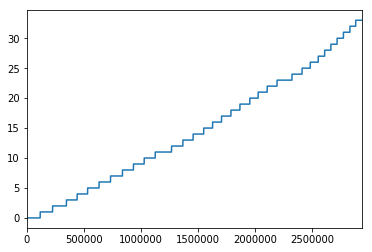

In [10]:
# The distribution of each date_block_num is balanced
sales.date_block_num.plot()

# Plot of shop_id against item_id on train and test data

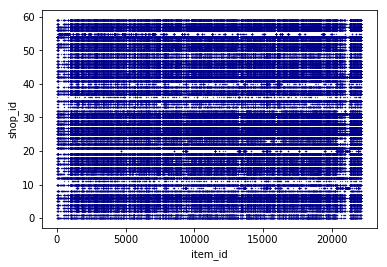

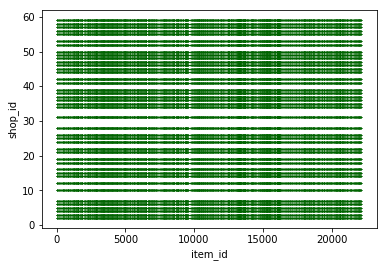

In [11]:
# Train data consists of sales/returns only, while test data was constructed as a cartesian product of all shops and items in the given month (shops * items) - so it will include a lot of "non-sales" occurrences
sales.drop_duplicates(subset=['item_id', 'shop_id']).plot.scatter('item_id', 'shop_id', color='DarkBlue', s = 0.1)
test.drop_duplicates(subset=['item_id', 'shop_id']).plot.scatter('item_id', 'shop_id', color='DarkGreen', s = 0.1)

In [12]:
# We can see that after merging sales data on test data, there is about 50% of missing values.
test.merge(sales, how='left', on=['shop_id', 'item_id']).isnull().sum()
test.shape[0]

ID                     0
shop_id                0
item_id                0
date              102796
date_block_num    102796
item_price        102796
item_cnt_day      102796
dtype: int64

214200

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,13.12.2013,11,12,6066,307980.0,1.0


,item_name,item_id,item_category_id
6066,Radmin 3 - 522 лиц.,6066,75


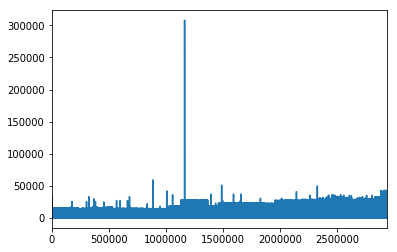

In [13]:
# Identify outliers in sales data. We found that there are some high price sales such as Radmin 3: Reliable Remote Support Software which more than USD 3468 or 200000 Russian Ruble.
sales.item_price.plot()
sales[sales['item_price'] > 100000]
items[items['item_id'] == 6066]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2326930,15.01.2015,24,12,20949,4.000000,1000.0
2909818,28.10.2015,33,12,11373,0.908714,2169.0


,item_name,item_id,item_category_id


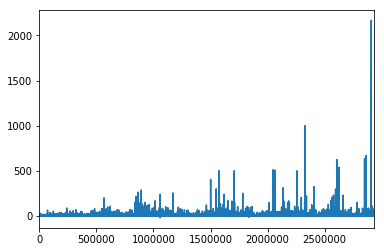

In [14]:
# For number of sales, there is an amount of sales more than 900. They are some kind of plastic bags and delivery services.
sales.item_cnt_day.plot()
sales[sales['item_cnt_day'] > 900]
items[(items['item_id'] == 11373) & (items['item_id'] == 20949)]

In [15]:
# Outliers above are removed so we only include item price that less than 100000 and amount of sales that less or equal to 900.
sales = sales[sales.item_price<100000]
sales = sales[sales.item_cnt_day<=900]

## Aggregate data

In [16]:
# Since the competition task is to make a monthly prediction, we need to aggregate the data to montly level before doing any encodings. The following code-cell serves just that purpose.
sales_m = sales.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': 'sum','item_price': np.mean}).reset_index()
sales_m = pd.merge(grid,sales_m,on=['date_block_num','shop_id','item_id'],how='left').fillna(0)

sales_m = pd.merge(sales_m,items,on=['item_id'],how='left')
sales_m = pd.merge(sales_m,item_category, on=['item_category_id'], how='left')

## Mean encoding

In [17]:
# We perform mean encoding on all category data which are item_id, shop_id and item_category_id
for type_id in ['item_id','shop_id','item_category_id']:
    for column_id, agg_func, func_name in [('item_price',np.mean,'avg'),('item_cnt_day',np.sum,'sum'),('item_cnt_day',np.mean,'avg')]:

        mean_df = sales_m.groupby([type_id,'date_block_num']).agg(agg_func).reset_index()[[column_id,type_id,'date_block_num']]
        mean_df.columns = [type_id+'_'+func_name+'_'+column_id, type_id,'date_block_num']
        
        sales_m = pd.merge(sales_m,mean_df,on=['date_block_num', type_id],how='left')

In [18]:
# We append test data into train data so we can create lag features on them
temp_test = test.copy()
temp_test['date_block_num'] = 34
temp_test.drop('ID', axis=1, inplace=True)

temp_test = temp_test.merge(items, how='left', on='item_id')
temp_test = temp_test.merge(item_category, how='left', on='item_category_id')
temp_test.drop('item_name', axis=1, inplace=True)

In [19]:
sales_m.drop('item_name', axis=1, inplace=True)
sales_m = pd.concat([sales_m,temp_test], axis=0, ignore_index=True)

We create lags on 10 features. 9 features are from mean encoding and 1 feature is the item_cnt_day.

After several tries, we found that month lag intervals of 1, 2, 3, 4, 5, 6, 9 and 12 give best score in the leaderboard. Take note that 16GB of ram is unable to compute such large number of interval. We need at least 64GB of ram.

In [20]:
lag_variables  = ['item_id_avg_item_price',
'item_id_sum_item_cnt_day',
'item_id_avg_item_cnt_day',
'shop_id_avg_item_price',
'shop_id_sum_item_cnt_day',
'shop_id_avg_item_cnt_day',
'item_category_id_avg_item_price',
'item_category_id_sum_item_cnt_day',
'item_category_id_avg_item_cnt_day',
'item_cnt_day']

#Limited by computation resource
lags = [1]
#lags = [1, 2, 3, 4, 5, 6, 9, 12]

for lag in lags:
    sales_new_df = sales_m.copy()
    sales_new_df.date_block_num+=lag
    sales_new_df = sales_new_df[['date_block_num','shop_id','item_id']+lag_variables]
    sales_new_df.columns = ['date_block_num','shop_id','item_id']+ [lag_feat+'_lag_'+str(lag) for lag_feat in lag_variables]
    sales_m = sales_m.merge(sales_new_df,on=['date_block_num','shop_id','item_id'] ,how='left')

In [21]:
sales_m.describe()

,date_block_num,item_category_id,item_category_id_avg_item_cnt_day,item_category_id_avg_item_price,item_category_id_sum_item_cnt_day,item_cnt_day,item_id,item_id_avg_item_cnt_day,item_id_avg_item_price,item_id_sum_item_cnt_day,item_price,shop_id,shop_id_avg_item_cnt_day,shop_id_avg_item_price,shop_id_sum_item_cnt_day,item_id_avg_item_price_lag_1,item_id_sum_item_cnt_day_lag_1,item_id_avg_item_cnt_day_lag_1,shop_id_avg_item_price_lag_1,shop_id_sum_item_cnt_day_lag_1,shop_id_avg_item_cnt_day_lag_1,item_category_id_avg_item_price_lag_1,item_category_id_sum_item_cnt_day_lag_1,item_category_id_avg_item_cnt_day_lag_1,item_cnt_day_lag_1
count,1.112805e+07,1.112805e+07,1.091385e+07,1.091385e+07,1.091385e+07,1.091385e+07,1.112805e+07,1.091385e+07,1.091385e+07,1.091385e+07,1.091385e+07,1.112805e+07,1.091385e+07,1.091385e+07,1.091385e+07,8.605461e+06,8.605461e+06,8.605461e+06,8.605461e+06,8.605461e+06,8.605461e+06,8.605461e+06,8.605461e+06,8.605461e+06,8.605461e+06
mean,1.533958e+01,4.494411e+01,3.339826e-01,1.165788e+02,8.501826e+03,3.339826e-01,1.130368e+04,3.339826e-01,1.165788e+02,1.563809e+01,1.165788e+02,3.119598e+01,3.339826e-01,1.165788e+02,2.375230e+03,1.397048e+02,1.904271e+01,4.066517e-01,1.167099e+02,2.390998e+03,3.348756e-01,1.217431e+02,8.750132e+03,3.512910e-01,4.075280e-01
std,9.760396e+00,1.514009e+01,1.638926e+00,3.204518e+02,8.973466e+03,3.334916e+00,6.210930e+03,2.041777e+00,4.436272e+02,9.621937e+01,6.518409e+02,1.735381e+01,2.644711e-01,6.043432e+01,1.952808e+03,4.914868e+02,1.071965e+02,2.273987e+00,6.006481e+01,1.952238e+03,2.637254e-01,3.378542e+02,9.017931e+03,1.812894e+00,3.578130e+00
min,0.000000e+00,0.000000e+00,-2.272727e-02,2.600000e-01,-1.000000e+00,-2.200000e+01,0.000000e+00,-4.888889e-01,0.000000e+00,-2.200000e+01,0.000000e+00,0.000000e+00,-1.966568e-04,2.329451e-02,-1.000000e+00,4.444444e-03,-2.200000e+01,-4.888889e-01,2.329451e-02,2.000000e+00,3.025261e-04,4.130435e-01,1.000000e+00,7.751938e-03,-2.200000e+01
25%,7.000000e+00,3.700000e+01,1.578334e-01,2.973899e+01,1.077000e+03,0.000000e+00,5.947000e+03,3.921569e-02,9.652174e+00,2.000000e+00,0.000000e+00,1.600000e+01,1.837063e-01,7.951914e+01,1.228000e+03,1.328889e+01,2.000000e+00,4.651163e-02,7.945678e+01,1.243000e+03,1.853114e-01,2.993934e+01,1.162000e+03,1.714948e-01,0.000000e+00
50%,1.500000e+01,4.000000e+01,2.254803e-01,4.557390e+01,5.959000e+03,0.000000e+00,1.138800e+04,8.695652e-02,2.706250e+01,4.000000e+00,0.000000e+00,3.000000e+01,2.560714e-01,1.026577e+02,1.807000e+03,3.481395e+01,6.000000e+00,1.276596e-01,1.026263e+02,1.816000e+03,2.566306e-01,4.569278e+01,6.088000e+03,2.285004e-01,0.000000e+00
75%,2.300000e+01,5.500000e+01,2.876345e-01,1.110535e+02,1.283400e+04,0.000000e+00,1.659200e+04,2.391304e-01,7.740851e+01,1.100000e+01,0.000000e+00,4.700000e+01,3.571321e-01,1.402056e+02,2.683000e+03,9.862222e+01,1.400000e+01,3.043478e-01,1.399021e+02,2.700000e+03,3.564936e-01,1.165383e+02,1.308400e+04,2.929805e-01,0.000000e+00
max,3.400000e+01,8.300000e+01,2.729783e+02,2.255054e+04,3.627700e+04,1.644000e+03,2.216900e+04,2.729783e+02,2.408645e+04,1.255700e+04,5.099900e+04,5.900000e+01,2.211961e+00,4.426968e+02,1.631800e+04,2.408645e+04,1.255700e+04,2.729783e+02,4.426968e+02,1.631800e+04,2.211961e+00,2.255054e+04,3.627700e+04,2.729783e+02,1.305000e+03


In [22]:
# Fill missing values
for feat in sales_m.columns:
    if 'item_cnt' in feat:
        sales_m[feat]=sales_m[feat].fillna(0)
    elif 'item_price' in feat:
        sales_m[feat]=sales_m[feat].fillna(sales_m[feat].median())

In [23]:
# Drop uneccesary columns and take data only after 12 since the most lag month interval is 12.
cols_to_drop = lag_variables[:-1] + ['item_price']
sales_m = sales_m[sales_m['date_block_num']>12]

## Validation

We use holdout scheme for cross validation. We use sales month from 12 to 32 for training, month 33 for validation and month 34 for testing.

In [24]:
X_train = sales_m[sales_m['date_block_num']<33].drop(cols_to_drop, axis=1)
X_cv =  sales_m[sales_m['date_block_num']==33].drop(cols_to_drop, axis=1)
X_test = sales_m[sales_m['date_block_num']==34].drop(cols_to_drop, axis=1)

## Reference from discussion

From discussion in Kaggle forum, we applied this useful trick, which clip the item_cnt_day within 40 instead of 20. In this way, there are more predictions on item_cnt_day = 20.

In [25]:
X_train['item_cnt_day'].clip_upper(40, inplace=True)
X_train['item_cnt_day'].clip_lower(0, inplace=True)

X_cv['item_cnt_day'].clip_upper(40, inplace=True)
X_cv['item_cnt_day'].clip_lower(0, inplace=True)

X_test['item_cnt_day'].clip_upper(40, inplace=True)
X_test['item_cnt_day'].clip_lower(0, inplace=True)

In [26]:
X_train.to_csv('data/X_train.csv', index=False)
X_cv.to_csv('data/X_cv.csv', index=False)
X_test.to_csv('data/X_test.csv', index=False)

# Model training

We decide to train the model with xgboost. We run through grid search for hyperparameters with hyperopt_xgb notebook. Since it is too time consuming, we stop it halfway, and tune them manually on top of the given suboptimized hyperparameters computed

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
from multiprocessing import Pool
import xgboost as xgb
from itertools import product
import pickle
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [28]:
test = pd.read_csv('data/test.csv')
X_train = pd.read_csv('data/X_train.csv')
X_cv = pd.read_csv('data/X_cv.csv')
X_test = pd.read_csv('data/X_test.csv')

In [31]:
#params = {
#        'eta': 0.08, #best 0.08
#        'max_depth': 7,
#        'objective': 'reg:linear',
#        'eval_metric': 'rmse',
#        'seed': 3,
#        'gamma':1,
#        'silent': True
#    }

params = {'max_depth':10, 
         'subsample':1,
         'min_child_weight':0.5,
         'eta':0.3, 
         'num_round':1000, 
         'seed':1,
         'silent':0,
         'eval_metric':'rmse'}

In [33]:
cols = [c for c in X_train.columns if c not in ['item_category_name', 'date_block_num', 'item_cnt_day',]]

x1 = X_train[cols]
y1 = X_train['item_cnt_day']
#x2 = X_cv[cols]
#y2 = X_cv['item_cnt_day']

#model = xgb.train(params, xgb.DMatrix(x1, y1))

In [34]:
progress = dict()
xgbtrain = xgb.DMatrix(x1, y1)
watchlist  = [(xgbtrain,'train-rmse')]
bst = xgb.train(param, xgbtrain)

[12:20:45] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


# Predict

In [36]:
preds = bst.predict(xgb.DMatrix(X_test[cols]), ntree_limit=bst.best_ntree_limit)

# Result

In [38]:
from sklearn.metrics import mean_squared_error 
rmse = np.sqrt(mean_squared_error(preds,y1))
print(rmse)

ValueError: Found input variables with inconsistent numbers of samples: [214200, 5839576]

# Submit

In [40]:
test['item_cnt_month'] = preds.clip(0,20)
test.drop(['shop_id', 'item_id'], axis=1, inplace=True)
test.to_csv('data/submission_2.csv', index=False)